In [ ]:
import torch
import os
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import statistics
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from scipy.optimize import fmin_l_bfgs_b

#Model

In [ ]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
stl10_train = dsets.STL10(root='./data', split='train', download=True, transform=transforms.ToTensor())
stl10_test = dsets.STL10(root='./data', split='test', download=True, transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = DataLoader(stl10_train, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(stl10_test, batch_size=1, shuffle=True, num_workers=2)

In [ ]:
# # Define the AlexNet model
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10, dropout_prob=0.2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(256 * 6 * 6, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout_prob),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.classifier(x)
#         return x

In [ ]:
# # Instantiate the AlexNet model
# net = AlexNet()

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)


# Replace the last fully connected layer with a new layer for STL-10 dataset
num_features = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_features, 10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
trainloader

In [ ]:
# Train the model
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        alexnet.train()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()

In [ ]:
# Use the model for inference on the test data
correct = 0
total = 0
cnt=0
with torch.no_grad():
    for data in testloader:
        if cnt>500:
          break
        cnt+=1
        images, labels = data
        alexnet.train()
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the pre-trained AlexNet model on the test images: %d %%' % (100 * correct / total))

Accuracy of the pre-trained AlexNet model on the test images: 76 %


# Uncertanity

In [ ]:

def uncertainty(model,data,labels,times=50):
  l = []
  pred = []
  img_ind = []
  f = 0
  ff = 0
  acc = torch.zeros(1, 10)
  t = torch.ones(1, 10)
  p = torch.ones(1, 10)
  t = t * times
  data=data.reshape(1,3,96,96)
  labels = int(labels.item())
  for i in range(times):
    model.train()
    output = model(data)
    pred_y = torch.max(output, 1)[1].data.numpy().squeeze()
    pred.append(pred_y)
    l.append(output)
    
    m = nn.Softmax(dim=1);
    l[i] = m(l[i])
    acc = acc + l[i]
    if pred_y!=labels:
        f = 1
        ff = pred_y
  
  acc /= times
  p[0, labels] = 0
  acc = p - acc
  acc[0, labels] = (acc[0, labels])*(-1)

  return l, pred, acc, f, ff

In [ ]:
def normalize(ans):
    for i in range(len(ans)):
        with torch.no_grad(): 
            ans[i] = torch.Tensor.numpy(ans[i])
    ans = np.asarray(ans)
    ans = np.ones((1,10), float) - np.var(ans,axis=0)
    ans *= 100;
    return ans

In [ ]:
ans = []
imgs = []
pred = []
cnt = 0
total = 50
accuracy = []
ind = []
act = []
indf = []
model = alexnet

actual = torch.zeros(1, total)
for images, labels in testloader:
    imgs.append(images)
    if cnt >= total: 
        break
    res, pred_y, acc, f, ff = uncertainty(model, images, labels)
    res = normalize(res)
    pred.append(pred_y)
    ans.append(res)
    accuracy.append(acc)
    actual[0, cnt] = labels
    if f:
        ind.append(cnt)
        indf.append(ff)
        act.append(int(labels))
    cnt += 1
ans = torch.tensor(ans, dtype=torch.float)

<ipython-input-13-270bf5510931>:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  ans = torch.tensor(ans, dtype=torch.float)


In [ ]:
def correlation(ans, accuracy):
    corr = torch.zeros(1, ans.size()[0])
    for i in range(ans.size()[0]): 
        tensor1 = accuracy[i]
        tensor2 = ans[i]

        mean1 = torch.mean(tensor1)
        mean2 = torch.mean(tensor2)

        tensor1 = tensor1 - mean1
        tensor2 = tensor2 - mean2

        res = torch.sum(torch.mul(tensor1, tensor2)) / (torch.sqrt(torch.sum(torch.mul(tensor1, tensor1))) * torch.sqrt(torch.sum(torch.mul(tensor2, tensor2))))
        if (torch.sqrt(torch.sum(torch.mul(tensor1, tensor1))) * torch.sqrt(torch.sum(torch.mul(tensor2, tensor2)))) == 0: 
            corr[0,i] = 1
        else:
            corr[0, i] = res
    return corr

In [ ]:
def plot(x, y):
    figure = plt.figure(figsize=(20, 5))

    figure.add_subplot(1, 3, 1)
    plt.scatter(x, y)

    plt.subplot(1, 3, 2)
    sns.set(style="whitegrid")
    sns.stripplot(x=x, y=y, jitter=0.2)

    #plt.subplot(1, 3, 3)
    #sns.kdeplot(x,y, shade = True, cbar=True)


    plt.show()

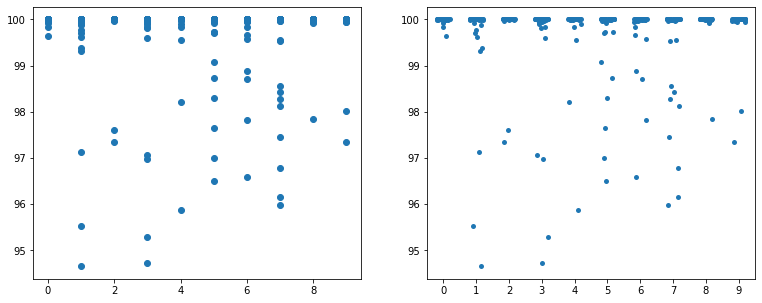

In [ ]:
x = []
y = []

for i in range(50):
    for j in range(10):
        x.append(j)
        y.append(float(ans[i][0, j]))

plot(x, y)

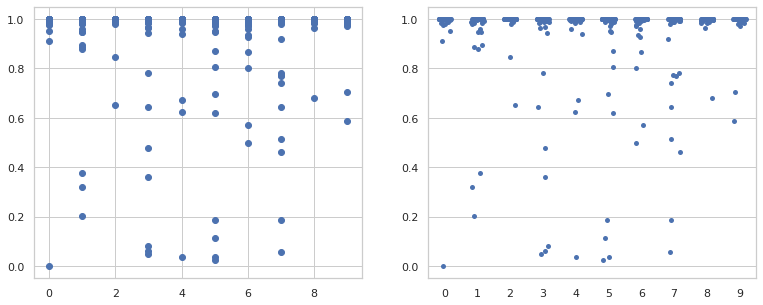

In [ ]:
x1 = []
y1 = []

for i in range(50):
    for j in range(10):
        x1.append(j)
        y1.append(float(accuracy[i][0, j]))

plot(x1, y1)

In [ ]:
def relation(j):
    a = []
    b = []

    for i in range(50):
        a.append(float(accuracy[i][0, j]))
        b.append(float(ans[i][0, j]))
    plot(a, b);
    return a, b

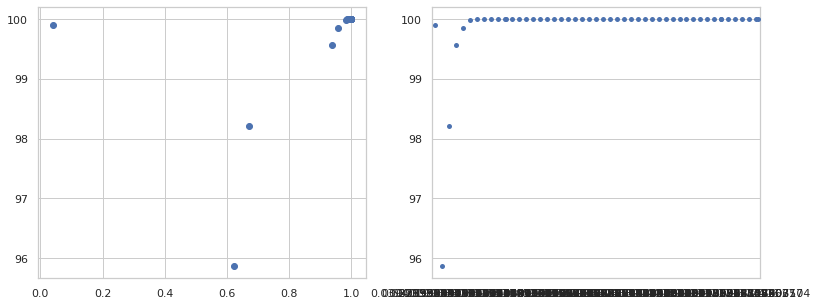

In [ ]:

a, b = relation(4)

In [ ]:
def plot_image(unc,acc,a,b):
    images_index=[]
    for i in range(len(a)):
        if a[i]<=unc and b[i]<=acc:
            images_index.append(i)
    return images_index

In [ ]:
plot_image(0.2, 100, a, b)

[15]

#Adversarial Attack

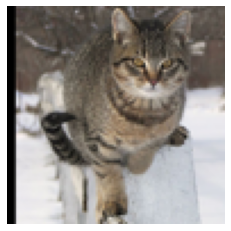

In [ ]:
img,lbl=stl10_test[23]
img=img.numpy()
img = np.transpose(img,(1,2,0))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
img = np.transpose(img,(2,1,0))
img.shape

(3, 96, 96)

In [ ]:
# def lbfgs_attack(model, loss_fn, x, y, eps=0.1, max_iter=20):
#     # Set the model in evaluation mode
#     model.eval()
    
#     # Create a copy of the input tensor as a starting point for the attack
#     x_adv = x.detach().clone().requires_grad_(True)

#     # Define the L-BFGS optimizer
#     optimizer = optim.LBFGS([x_adv], max_iter=max_iter)

#     # Define a closure function to compute the loss and gradient
#     def closure():
#         optimizer.zero_grad()
#         tmp= model(x_adv)
#         loss = loss_fn(tmp, y)
#         loss.backward()
#         return loss

#     # Run the L-BFGS optimizer to generate the adversarial example
#     for i in range(max_iter):
#         # Compute the loss and gradient
#         loss = optimizer.step(closure)

#         # Clip the adversarial example to ensure it stays within the epsilon ball around the original example
#         delta = torch.clamp(x_adv - x, min=-eps, max=eps)
#         x_adv.data.copy_(torch.clamp(x + delta, min=0, max=1).data)

#     return x_adv

In [ ]:
def lbfgs_attack(model, images, labels, epsilon=0.1, num_steps=10):
    images = images.clone().detach().requires_grad_(True)
    optimizer = optim.LBFGS([images])
    loss_fn = F.cross_entropy
    for i in range(num_steps):
        def closure():
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            return loss

        optimizer.step(closure)
        images.data = torch.clamp(images.data, 0, 1)

    adv_images = images.detach()
    return adv_images

In [ ]:
lbfgs_attack(alexnet,torch.tensor(img).unsqueeze(dim=0),torch.tensor(lbl).unsqueeze(dim=0))

torch.Size([1, 3, 96, 96])


RuntimeError: ignored

In [ ]:
# def lbfgs_attack(model, loss_fn, x, y, eps=0.1, max_iter=20):
#     # Set the model in evaluation mode
#     model.eval()
    
#     # Create a copy of the input tensor as a starting point for the attack
#     # x_adv = x.requires_grad_(True)

#     # Define the L-BFGS optimizer
#     optimizer = optim.LBFGS([x_adv], max_iter=max_iter)

#     # Define a closure function to compute the loss and gradient
#     def closure():
#         optimizer.zero_grad()
#         tmp= model(x_adv)
#         loss = loss_fn(tmp, y)
#         loss.backward()
#         return loss

#     # Run the L-BFGS optimizer to generate the adversarial example
#     for i in range(max_iter):
#         # Compute the loss and gradient
#         loss = optimizer.step(closure)

#         # Clip the adversarial example to ensure it stays within the epsilon ball around the original example
#         delta = torch.clamp(x_adv - x, min=-eps, max=eps)
#         x_adv.data.copy_(torch.clamp(x + delta, min=0, max=1).data)

#     return x_adv

In [ ]:
def sen(x):
    sen_image = []
    x = x.squeeze()
    for l in range(3):
        t = []
        for i in range (96):
            var = []
            for j in range (96):
                n = 0
                mu = 0
                for k in range(-1,2,1):
                    for z in range (-1,2,1):
                        if i+k>=96 or i+k<0 or j+z>=96 or j+z<0 :
                            continue
                        n += 1
                        mu += x[l][i+k][j+z]
                mu = mu/n
                s = 0
                for k in range(-1,2,1):
                    for z in range (-1,2,1):
                        if i+k>=96 or i+k<0 or j+z>=96 or j+z<0 :
                            continue
                        s += (x[l][i+k][j+z]-mu)*(x[l][i+k][j+z]-mu)
                s = s/n*n
                s = math.sqrt(s)
                if s == 0: 
                    s = 0.0001
                var.append(1/s)
            t.append(var)
        sen_image.append(t)
    return sen_image


In [ ]:
def gap(x,model,target,k=100):
  output= model(x)
  m = nn.Softmax(dim=1)
  output = m(output)
  pt=output[0, target]
  sum = 0
  for i in range(10):
      if i != target.item() :
        sum += torch.exp(k*output[0, i])
  return pt - torch.log(sum)/k

In [ ]:
def perturb_priority(x,target,sensitivity):
  perturb = []
  delta = 0.1
  for c in range(3):
    for i in range(96):
        for j in range(96):
            with torch.no_grad():
                g_x = gap(x,model,target)
                x[0][c][i][j] += torch.tensor(delta)
                g_x_e = gap(x,model,target)
                x[0][c][i][j] -= torch.tensor(delta)
                grad = (g_x_e - g_x)/delta
                perturb.append(grad/sensitivity[c][i][j])
  return torch.tensor(perturb)
  

In [ ]:
def our_method(img,target,model,Dmax,delta,m):
  D=0
  while D<Dmax:
    D=0
    sensitivity=sen(img)
    perturb_list=perturb_priority(img,target,sensitivity)
    sorted_perturb,indices=torch.sort(perturb_list,descending=True)
    print(D)
    with torch.no_grad():
      for i in range(m):
        indices[i] = int(indices[i]/3)
        x = indices[i]/96
        y = indices[i]%96
        x = x.item()
        y = y.item()
        x = int(x)
        y = int(y)
        z = torch.zeros(img.shape)
        z[0][0][x][y] += torch.tensor(delta)
        img = torch.add(img,z)
        D += delta*sensitivity[x][y]
        print(D)
  return img

In [ ]:
#y = our_method(torch.tensor(img).unsqueeze(dim=0),torch.tensor(lbl),alexnet,0.01,0.25,20)

In [ ]:
images=[]
labels=[]
for i,l in testloader:
  images.append(i)
  labels.append(l)

In [ ]:
#alexnet(torch.tensor(img))

In [ ]:
# y=y.numpy()
# y = np.transpose(y,(1,2,0))
# plt.imshow(y)
# plt.axis('off')
# plt.show()

In [ ]:
lbl=torch.tensor(lbl, dtype=torch.int8)

In [ ]:
def fgsm_attack(model, images, labels, epsilon=0.05):
    images = images.clone().detach().requires_grad_(True)
    loss_fn = F.cross_entropy

    outputs = model(images)
    loss = loss_fn(outputs, labels)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data.sign()
    adv_images = images + epsilon * gradient
    adv_images = torch.clamp(adv_images, 0, 1).detach()
    return adv_images

In [ ]:
fgsm_image=fgsm_attack(alexnet,torch.tensor(img).unsqueeze(dim=0),torch.tensor(lbl).unsqueeze(dim=0),0.05)

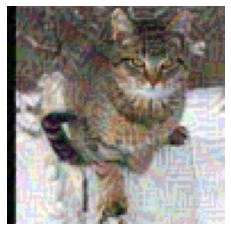

In [ ]:

y=fgsm_image
y=y.squeeze()
y=y.numpy()
y = np.transpose(y,(2,1,0))
plt.imshow(y)
plt.axis('off')
plt.show()